Veri yükleniyor...
Eğitim başlıyor...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.2155 - auc: 0.6986 - loss: 0.5010 - val_accuracy: 0.3400 - val_auc: 0.9031 - val_loss: 0.2146
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3434 - auc: 0.8507 - loss: 0.2522 - val_accuracy: 0.3400 - val_auc: 0.9120 - val_loss: 0.1946
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3751 - auc: 0.8795 - loss: 0.2348 - val_accuracy: 0.3400 - val_auc: 0.9079 - val_loss: 0.1881
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3266 - auc: 0.8813 - loss: 0.2365 - val_accuracy: 0.3400 - val_auc: 0.9106 - val_loss: 0.1907
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3252 - auc: 0.8927 - loss: 0.2228 - val_accuracy: 0.3400 - val_auc: 0.9193 - val_loss: 0.1878
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3187 - auc: 0.8875 - loss: 0.2220 - val_accuracy: 0.3400 - val_auc: 0.9137 - val_loss: 0.1886
Epoch 7/10
13/

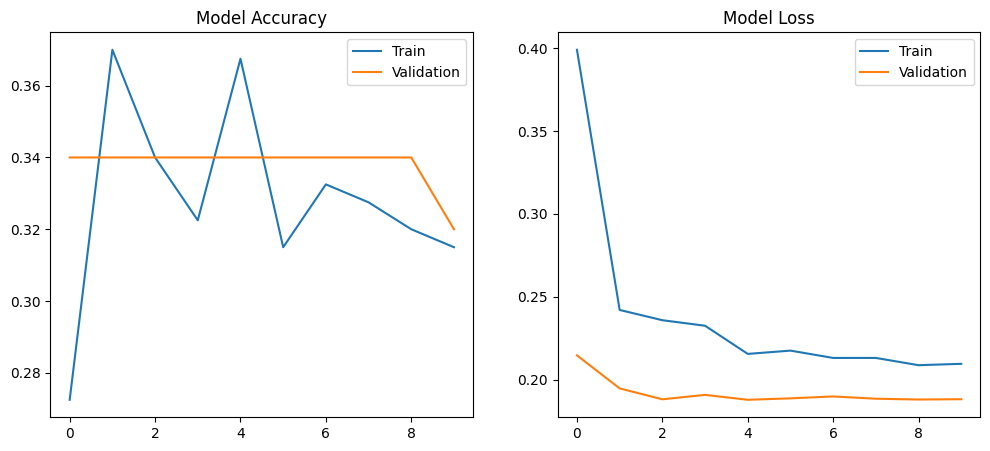

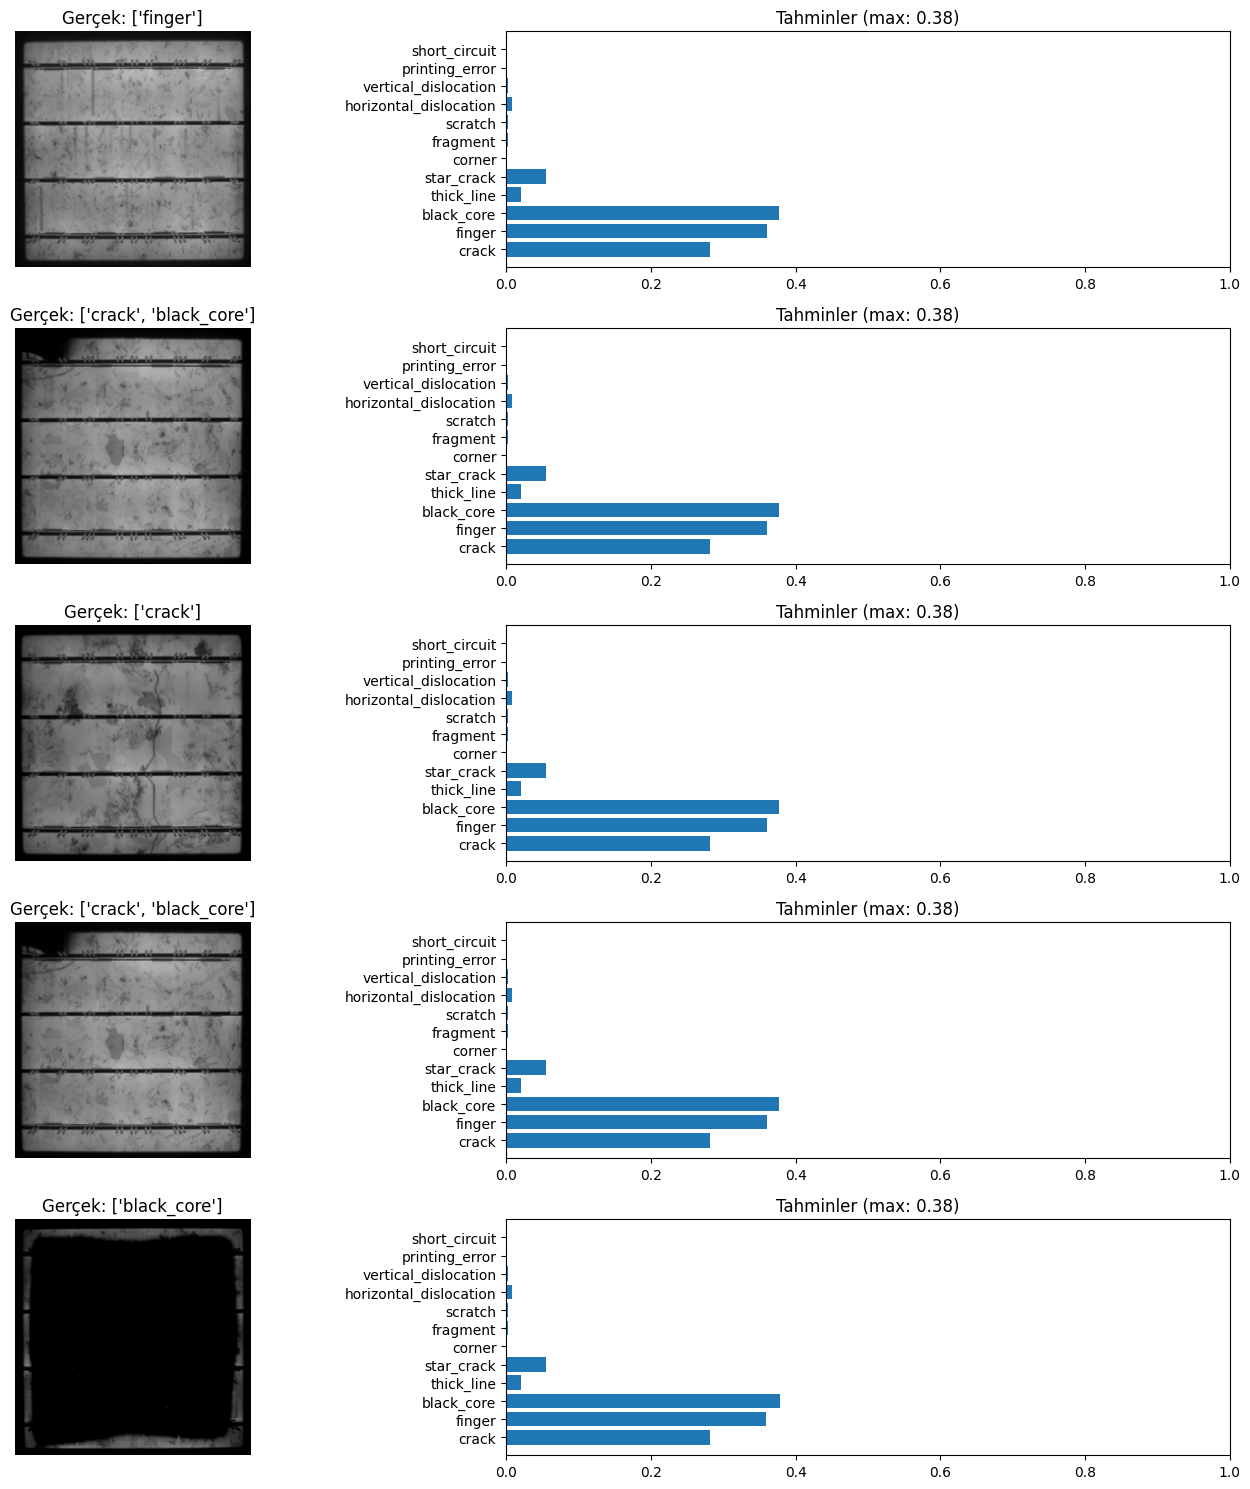

In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Veri yolları ve parametreler
base_dir = 'C:/Users/gokha/Desktop/Zentech/solar_cell_EL_image/solar_cell_EL_image/PVELAD/EL2021'
jpeg_dir = os.path.join(base_dir, 'trainval/JPEGImages')
annot_dir = os.path.join(base_dir, 'trainval/Annotations')
class_names = ['crack', 'finger', 'black_core', 'thick_line', 'star_crack',
               'corner', 'fragment', 'scratch', 'horizontal_dislocation',
               'vertical_dislocation', 'printing_error', 'short_circuit']
num_classes = len(class_names)
batch_size = 32
epochs = 10

# Özel veri yükleyici sınıfı
class PVELDataGenerator(utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augment=False, **kwargs):
        super().__init__(**kwargs)  # Kritik düzeltme
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(x_set))
        
        # Basit veri artırma
        self.datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest') if augment else None

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x = np.array([self.x[i] for i in batch_indices])
        batch_y = np.array([self.y[i] for i in batch_indices])
        
        if self.augment:
            # Veri artırma uygula
            batch_x = np.stack([self.datagen.random_transform(img) for img in batch_x])
            
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.augment:
            np.random.shuffle(self.indices)

# Veri yükleme fonksiyonu
def load_data(jpeg_dir, annot_dir, sample_limit=500):
    images, labels = [], []
    
    for i, xml_file in enumerate(os.listdir(annot_dir)):
        if sample_limit and len(images) >= sample_limit:
            break
            
        if not xml_file.endswith('.xml'):
            continue
            
        try:
            # [Önceki veri yükleme kodunuz...]
            tree = ET.parse(os.path.join(annot_dir, xml_file))
            root = tree.getroot()
            img_name = root.find('filename').text
            img_path = os.path.join(jpeg_dir, img_name)
            
            if not os.path.exists(img_path):
                continue
                
            img_labels = np.zeros(num_classes, dtype='float32')
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name in class_names:
                    class_idx = class_names.index(class_name)
                    img_labels[class_idx] = 1.0
            
            img = Image.open(img_path).resize((256, 256))
            img_array = np.array(img)
            
            if len(img_array.shape) == 2:
                img_array = np.stack((img_array,)*3, axis=-1)
            img_array = img_array[:,:,:3] / 255.0
            
            images.append(img_array)
            labels.append(img_labels)
            
        except Exception as e:
            print(f"Skipping {xml_file}: {str(e)}")
            continue
    
    return np.array(images), np.array(labels)

# Veriyi yükle
print("Veri yükleniyor...")
X, y = load_data(jpeg_dir, annot_dir, sample_limit=500)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data generator'ları oluştur
train_gen = PVELDataGenerator(X_train, y_train, batch_size, augment=True)
val_gen = PVELDataGenerator(X_val, y_val, batch_size)

# Model oluştur
model = models.Sequential([
    EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights='imagenet'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='sigmoid')
])
model.layers[0].trainable = False  # Feature extractor'ı dondur

model.compile(optimizer=Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# Eğitim
print("Eğitim başlıyor...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1)

# Sonuçları göster
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# Örnek tahminler
def show_results(model, X, y, num_samples=5):
    indices = np.random.choice(len(X), num_samples)
    plt.figure(figsize=(15, 3*num_samples))
    
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = y[idx]
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(img)
        true_classes = [class_names[i] for i, val in enumerate(true_label) if val > 0.5]
        plt.title(f"Gerçek: {true_classes if true_classes else 'Kusursuz'}")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2*i+2)
        plt.barh(class_names, pred)
        plt.xlim(0, 1)
        plt.title(f"Tahminler (max: {max(pred):.2f})")
    
    plt.tight_layout()
    plt.show()

show_results(model, X_val, y_val)